RL - CIA2

Problem : Create a 100x100 grid with obstacles in between 2 random points. Build an MDP based RL agent to optimise both policies and actions at every state. Benchmark DP method with other RL solutions for the same problem.


In [67]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

Grid and Environment setup

In [68]:
GRID_SIZE = 100  # 100x100 grid
OBSTACLE_RATIO = 0.2  # 20% obstacles

Initialising grid with obstacles

In [69]:
grid = np.zeros((GRID_SIZE, GRID_SIZE))
num_obstacles = int(OBSTACLE_RATIO * GRID_SIZE * GRID_SIZE)
obstacle_positions = random.sample([(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)], num_obstacles)
for (x, y) in obstacle_positions:
    grid[x, y] = -1  # obstacles -> -1

Random Start - Stop points

In [70]:
start = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
end = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
while grid[start] == -1 or grid[end] == -1:  #condition for start , stop points to not be an obstacle
    start = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))
    end = (random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1))

In [71]:
grid[end] = 1 #goal score

In [72]:
ACTIONS = [(0, 1), (1, 0), (0, -1), (-1, 0)]
REWARD_GOAL = 100
REWARD_STEP = -1
REWARD_OBSTACLE = -100

To take an action and get the next state and reward

In [73]:
def get_next_state(state, action):
    x, y = state
    dx, dy = action
    nx, ny = x + dx, y + dy
    if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
        if grid[nx, ny] == -1:
            return state, REWARD_OBSTACLE
        elif (nx, ny) == end:
            return (nx, ny), REWARD_GOAL
        else:
            return (nx, ny), REWARD_STEP
    return state, REWARD_STEP

Value Iteration algorithm

In [74]:
def value_iteration(grid, gamma=0.9, theta=1e-4):
    value_grid = np.zeros_like(grid, dtype=float)
    policy_grid = np.zeros_like(grid, dtype=int)
    while True:
        delta = 0
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if grid[x, y] == -1 or (x, y) == end:
                    continue
                state = (x, y)
                max_value = float('-inf')
                best_action = 0
                for i, action in enumerate(ACTIONS):
                    (nx, ny), reward = get_next_state(state, action)
                    value = reward + gamma * value_grid[nx, ny]
                    if value > max_value:
                        max_value = value
                        best_action = i
                delta = max(delta, abs(max_value - value_grid[x, y]))
                value_grid[x, y] = max_value
                policy_grid[x, y] = best_action
        if delta < theta:
            break
    return value_grid, policy_grid

Q-learning algorithm

In [75]:
def q_learning(grid, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    q_table = np.zeros((GRID_SIZE, GRID_SIZE, len(ACTIONS)))
    for episode in range(episodes):
        state = start
        while state != end:
            x, y = state
            if random.uniform(0, 1) < epsilon:
                action_index = random.randint(0, len(ACTIONS) - 1)
            else:
                action_index = np.argmax(q_table[x, y])
            action = ACTIONS[action_index]
            (nx, ny), reward = get_next_state(state, action)
            best_next_action = np.argmax(q_table[nx, ny])
            q_table[x, y, action_index] += alpha * (reward + gamma * q_table[nx, ny, best_next_action] - q_table[x, y, action_index])
            state = (nx, ny) if reward != REWARD_OBSTACLE else state
    return q_table

In [76]:
def visualize_path(policy_grid, path_color='yellow', title="Optimal Path"):
    x, y = start
    path = [start]
    cost = 0
    while (x, y) != end:
        action = policy_grid[x, y]
        dx, dy = ACTIONS[action]
        x, y = x + dx, y + dy
        if (x, y) in path:  # Prevent loops
            break
        path.append((x, y))
        _, reward = get_next_state((x, y), ACTIONS[action])
        cost += reward
        if len(path) > GRID_SIZE**2:
            break
    plt.imshow(grid, cmap='gray')
    plt.plot([y for x, y in path], [x for x, y in path], color=path_color, label="Path")
    plt.scatter(start[1], start[0], color='blue', label="Start")
    plt.scatter(end[1], end[0], color='red', label="Goal")
    plt.legend()
    plt.axis('off')
    plt.title(title)
    plt.show()
    return path, cost

In [77]:
def visualize_q_path(q_table, path_color='green', title="Optimal Path (Q-Learning)"):
    x, y = start
    path = [start]
    cost = 0
    visited = set()
    while (x, y) != end:
        visited.add((x, y))
        action_index = np.argmax(q_table[x, y])
        dx, dy = ACTIONS[action_index]
        nx, ny = x + dx, y + dy
        if (nx, ny) in visited:
            break
        path.append((nx, ny))
        _, reward = get_next_state((x, y), ACTIONS[action_index])
        cost += reward
        x, y = nx, ny
        if len(path) > GRID_SIZE**2:
            break
    plt.imshow(grid, cmap='gray')
    plt.plot([y for x, y in path], [x for x, y in path], color=path_color, label="Path")
    plt.scatter(start[1], start[0], color='blue', label="Start")
    plt.scatter(end[1], end[0], color='red', label="Goal")
    plt.legend()
    plt.axis('off')
    plt.title(title)
    plt.show()
    return path, cost

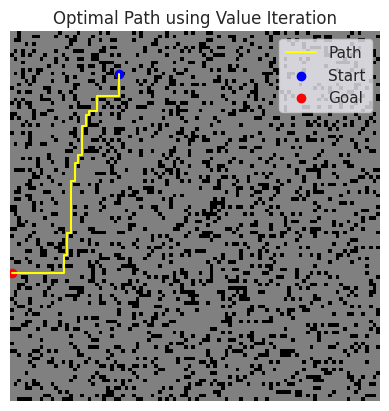

In [78]:
start_time = time.time()
value_grid, policy_grid = value_iteration(grid)
dp_time = time.time() - start_time
dp_route, dp_cost = visualize_path(policy_grid, path_color='yellow', title="Optimal Path using Value Iteration")
dp_route_length = len(dp_route)


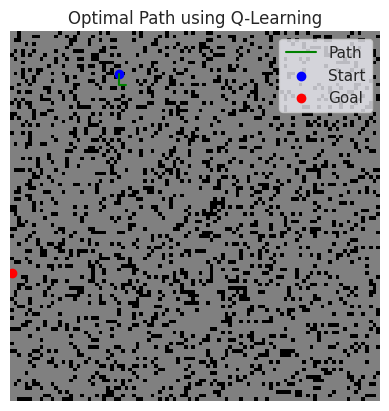

In [79]:
q_episodes = 1000
start_time = time.time()
q_table = q_learning(grid, episodes=q_episodes)
q_time = time.time() - start_time
q_route, q_cost = visualize_q_path(q_table, path_color='green', title="Optimal Path using Q-Learning")
q_route_length = len(q_route)

In [80]:
print("\nPerformance Comparison:")
print("=" * 40)
print("Dynamic Programming (Value Iteration):")
print(f"  Route Length: {dp_route_length}")
print(f"  Convergence Cycles: ~{dp_route_length}")
print(f"  Processing Time: {dp_time:.2f} seconds")
print(f"  Total Path Cost: {dp_cost}")
print("\nQ-Learning:")
print(f"  Route Length: {q_route_length}")
print(f"  Training Episodes: {q_episodes}")
print(f"  Processing Time: {q_time:.2f} seconds")
print(f"  Total Path Cost: {q_cost}")
print("=" * 40)


Performance Comparison:
Dynamic Programming (Value Iteration):
  Route Length: 84
  Convergence Cycles: ~84
  Processing Time: 7.93 seconds
  Total Path Cost: -873

Q-Learning:
  Route Length: 6
  Training Episodes: 1000
  Processing Time: 39.32 seconds
  Total Path Cost: -5
